# **Course project on Technologies and Infrastructure for Big Data**
part I : image collecting from flickr


Project topic: image segmentation with data collection from www.flickr.com database 

Project executors:

Ma Cheng Yuan , ISU 372818 , J4133c

In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=4552a6b994458d40a2e80d8aaab74fc273555f4958fb04e62974fdbea10f76d7
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [2]:
pip install flickrapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.2 MB/s eta 0:00:00


In [3]:
import pyspark.pandas as ps
import flickrapi
from flickrapi import FlickrAPI
import os
import warnings

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.9/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


Download image from flick with flickrapi

- image segmentation , all_species = ['blue jay', 'northern cardinal', 'american goldfinch'] , each specie with 10 image 

- image generation , only blue jay with 50000 

In [4]:
from flickrapi import FlickrAPI
from pyspark.sql import SparkSession
from pyspark.sql.types import *

API_KEY = '513e24d8fc90dd4f767670d583ba1e41'
API_SECRET = '975b054fcd3c3371'
api = flickrapi.FlickrAPI(api_key=API_KEY, secret=API_SECRET, format='parsed-json')


def get_photos(image_tag):
    extras = ','.join(SIZES)
    flickr = FlickrAPI(API_KEY, API_SECRET)
    photos = flickr.walk(text=image_tag,
                            extras="url_c",  # get the url for the original size image
                            privacy_filter=1,  # search only for public photos
                            per_page=500,
                            sort='relevance')
    
  
    
    return photos

def get_url(photo):
      url = photo.get('url_c')     
    
      if url:  # if url is None try with the next size
          return url

def get_urls(image_tag, max):
    photos = get_photos(image_tag)
    counter=0
    urls=[]

    for photo in photos:
        if counter < max:
            url = get_url(photo)  # get preffered size url
            if url:
                urls.append(url)
                counter += 1
            # if no url for the desired sizes then try with the next photo
        else:
            break

    return urls

In [5]:
import requests
import os
import sys

def create_folder(path):
    if not os.path.isdir(path):
        os.makedirs(path)

def download_images(urls, path):
    create_folder(path)  # makes sure path exists
    local_storage = []
    for url in urls:
        image_name = url.split("/")[-1]
        image_path = os.path.join(path, image_name)
        
        if not os.path.isfile(image_path):  # ignore if already downloaded
            response=requests.get(url,stream=True)

            with open(image_path,'wb') as outfile:
                outfile.write(response.content)
        local_storage.append(image_path)
    return local_storage

In [6]:
from pyspark.sql.readwriter import DataFrameReader
import os
import time

all_species = ['blue jay', 'northern cardinal', 'american goldfinch']
images_per_specie = 10
 
def download(urls,specie):
    fotos = []
    local_storage = []
    
    
    print('Getting urls for', specie)
    urls = urls

    print('Downlaing images for', specie)
    path = os.path.join('data', specie)
    
    
    local_storage = download_images(urls, path)
    
    return local_storage

from tqdm import tqdm
if __name__=='__main__':
  df = ps.DataFrame()
  labels = []
  size = 20
  flickr = FlickrAPI(API_KEY, API_SECRET)
  for label in all_species :
    page = 1
    dataframe = ps.DataFrame()
    print(label)    
    while(len(dataframe) < size):
      photos = api.photos.search(text=label, sort='relevance', media='photos',
                    extras='url_c', per_page=size, page=page)['photos']
      dataframe_specie = ps.DataFrame(photos['photo'])
      dataframe = ps.concat([dataframe, dataframe_specie], ignore_index=True)
      page = page + 1
  
    dataframe['label'] = [all_species.index(label)] * len(dataframe)
    dataframe = dataframe.dropna()
    urls = dataframe['url_c'].tolist()
    local_storage = download(urls,label)
    print(len(local_storage))
    print(len(dataframe))
    dataframe['root'] = local_storage
    df = ps.concat([df, dataframe], ignore_index=True)
  print(len(df))
 

blue jay
Getting urls for blue jay
Downlaing images for blue jay
19
19
19


convert files with images into zip files and download it to create masked images (label images) using VGG image annotator 

https://annotate.officialstatistics.org/

In [7]:
!zip -r /content/data.zip /content/data

  adding: content/data/ (stored 0%)
  adding: content/data/blue jay/ (stored 0%)
  adding: content/data/blue jay/11082504556_febcc53c05_c.jpg (deflated 0%)
  adding: content/data/blue jay/6265312062_13fc796c3a_c.jpg (deflated 0%)
  adding: content/data/blue jay/13188782053_7b421d9752_c.jpg (deflated 1%)
  adding: content/data/blue jay/21992539444_13c1342bbf_c.jpg (deflated 0%)
  adding: content/data/blue jay/14143181441_ffdc52e7c5_c.jpg (deflated 0%)
  adding: content/data/blue jay/11124157635_3c8aa26ddc_c.jpg (deflated 0%)
  adding: content/data/blue jay/31618404466_28bd67eef6_c.jpg (deflated 2%)
  adding: content/data/blue jay/8695246698_e949fbd20f_c.jpg (deflated 0%)
  adding: content/data/blue jay/30732405073_4570f0c65c_c.jpg (deflated 1%)
  adding: content/data/blue jay/27654220552_69e94ece66_c.jpg (deflated 0%)
  adding: content/data/blue jay/7950900098_a911c5cf1d_c.jpg (deflated 1%)
  adding: content/data/blue jay/16324923976_ec53ecbd59_c.jpg (deflated 1%)
  adding: content/data

In [ ]:
df

id            owner      secret server  farm                                                                                                            title  ispublic  isfriend  isfamily                                                             url_c  height_c  width_c  label                                        root
0    15811449023     24635080@N08  37fe513a03   8640     9                                                                                                         Blue Jay         1         0         0   https://live.staticflickr.com/8640/15811449023_37fe513a03_c.jpg     530.0    800.0      0  data/blue jay/15811449023_37fe513a03_c.jpg
1     5443398071     59461294@N04  0533d6924f   4142     5                                                                                                         Blue Jay         1         0         0    https://live.staticflickr.com/4142/5443398071_0533d6924f_c.jpg     533.0    800.0      0   data/blue jay/5443398071_0533d6924f_c.jpg
2     6101507958     49597255@N07  7fefab1ebb   6080     7                                                                                                         Blue Jay         1         0         0    https://live.staticflickr.com/6080/6101507958_7fefab1ebb_c.jpg     534.0    800.0      0   data/blue jay/6101507958_7fefab1ebb_c.jpg
3     5151164742     44845082@N06  0acfdff8ac   4019     5                                                                                                         blue jay         1         0         0    https://live.staticflickr.com/4019/5151164742_0acfdff8ac_c.jpg     477.0    800.0      0   data/blue jay/5151164742_0acfdff8ac_c.jpg
4     4613169557     86188061@N00  110efcd5ef   4026     5                                                                                                         Blue Jay         1         0         0    https://live.staticflickr.com/4026/4613169557_110efcd5ef_c.jpg     601.0    800.0      0   data/blue jay/4613169557_110efcd5ef_c.jpg
5    11142547155     25643797@N03  a940f7087f   7337     8                                                                                                         Blue Jay         1         0         0   https://live.staticflickr.com/7337/11142547155_a940f7087f_c.jpg     581.0    800.0      0  data/blue jay/11142547155_a940f7087f_c.jpg
6     8352777065     16016001@N08  237ed8ca36   8093     9                                                                                                         Blue Jay         1         0         0    https://live.staticflickr.com/8093/8352777065_237ed8ca36_c.jpg     640.0    800.0      0   data/blue jay/8352777065_237ed8ca36_c.jpg
7     5642180820     36678894@N06  c670167fb8   5108     6                                                                                                         Blue Jay         1         0         0    https://live.staticflickr.com/5108/5642180820_c670167fb8_c.jpg     800.0    640.0      0   data/blue jay/5642180820_c670167fb8_c.jpg
8    25636420852     75558468@N07  4e433341aa   1657     2                                                                                                         Blue Jay         1         0         0   https://live.staticflickr.com/1657/25636420852_4e433341aa_c.jpg     800.0    737.0      0  data/blue jay/25636420852_4e433341aa_c.jpg
9    30957745352     41755442@N06  21a6ed6650   5536     6                                                                                                         Blue Jay         1         0         0   https://live.staticflickr.com/5536/30957745352_21a6ed6650_c.jpg     533.0    800.0      0  data/blue jay/30957745352_21a6ed6650_c.jpg
10    2003680737     20638340@N05  6b61c979d3   2228     3                                                                                                         Blue Jay         1         0         0    https://live.staticflickr.com/2228/2003680737_6b61c979d3_c.jpg     540.0    800.0      0   

In [ ]:
df = df[['root','label','url_c']]

In [ ]:
df

root  label                                                             url_c
0    data/blue jay/15811449023_37fe513a03_c.jpg      0   https://live.staticflickr.com/8640/15811449023_37fe513a03_c.jpg
1     data/blue jay/5443398071_0533d6924f_c.jpg      0    https://live.staticflickr.com/4142/5443398071_0533d6924f_c.jpg
2     data/blue jay/6101507958_7fefab1ebb_c.jpg      0    https://live.staticflickr.com/6080/6101507958_7fefab1ebb_c.jpg
3     data/blue jay/5151164742_0acfdff8ac_c.jpg      0    https://live.staticflickr.com/4019/5151164742_0acfdff8ac_c.jpg
4     data/blue jay/4613169557_110efcd5ef_c.jpg      0    https://live.staticflickr.com/4026/4613169557_110efcd5ef_c.jpg
5    data/blue jay/11142547155_a940f7087f_c.jpg      0   https://live.staticflickr.com/7337/11142547155_a940f7087f_c.jpg
6     data/blue jay/8352777065_237ed8ca36_c.jpg      0    https://live.staticflickr.com/8093/8352777065_237ed8ca36_c.jpg
7     data/blue jay/5642180820_c670167fb8_c.jpg      0    https://live.staticflickr.com/5108/5642180820_c670167fb8_c.jpg
8    data/blue jay/25636420852_4e433341aa_c.jpg      0   https://live.staticflickr.com/1657/25636420852_4e433341aa_c.jpg
9    data/blue jay/30957745352_21a6ed6650_c.jpg      0   https://live.staticflickr.com/5536/30957745352_21a6ed6650_c.jpg
10    data/blue jay/2003680737_6b61c979d3_c.jpg      0    https://live.staticflickr.com/2228/2003680737_6b61c979d3_c.jpg
11   data/blue jay/31871973222_60f9f9d1d3_c.jpg      0    https://live.staticflickr.com/581/31871973222_60f9f9d1d3_c.jpg
12    data/blue jay/4536710497_5d11917cee_c.jpg      0    https://live.staticflickr.com/4019/4536710497_5d11917cee_c.jpg
13    data/blue jay/6302625014_5d44f67ba5_c.jpg      0    https://live.staticflickr.com/6059/6302625014_5d44f67ba5_c.jpg
14    data/blue jay/5833818983_e15990c3d0_c.jpg      0    https://live.staticflickr.com/5036/5833818983_e15990c3d0_c.jpg
15   data/blue jay/26697017633_0dc74a636a_c.jpg      0   https://live.staticflickr.com/7485/26697017633_0dc74a636a_c.jpg
16   data/blue jay/15369793464_7188ed0950_c.jpg      0   https://live.staticflickr.com/7540/15369793464_7188ed0950_c.jpg
17   data/blue jay/22506516545_fe40197b38_c.jpg      0    https://live.staticflickr.com/715/22506516545_fe40197b38_c.jpg
18    data/blue jay/5271588596_b1d8fe96a3_c.jpg      0    https://live.staticflickr.com/5170/5271588596_b1d8fe96a3_c.jpg
19    data/blue jay/4018696902_a324d1e1c8_c.jpg      0    https://live.staticflickr.com/2734/4018696902_a324d1e1c8_c.jpg
20   data/blue jay/16038013416_40503099cb_c.jpg      0   https://live.staticflickr.com/7577/16038013416_40503099cb_c.jpg
21    data/blue jay/5337132041_71b777980b_c.jpg      0    https://live.staticflickr.com/5164/5337132041_71b777980b_c.jpg
22    data/blue jay/6803631930_d8cb28f9ab_c.jpg      0    https://live.staticflickr.com/7197/6803631930_d8cb28f9ab_c.jpg
23   data/blue jay/30561915126_b90a7b9983_c.jpg      0   https://live.staticflickr.com/5637/30561915126_b90a7b9983_c.jpg
24   data/blue jay/32224492462_7a0d380671_c.jpg      0    https://live.staticflickr.com/717/32224492462_7a0d380671_c.jpg
25    data/blue jay/8018824606_407704c2e2_c.jpg      0    https://live.staticflickr.com/8032/8018824606_407704c2e2_c.jpg
26   data/blue jay/14489706086_19d9d22913_c.jpg      0   https://live.staticflickr.com/2921/14489706086_19d9d22913_c.jpg
27    data/blue jay/1261380871_1139ce1c5f_c.jpg      0    https://live.staticflickr.com/1438/1261380871_1139ce1c5f_c.jpg
28    data/blue jay/4855416752_67475e837b_c.jpg      0    https://live.staticflickr.com/4077/4855416752_67475e837b_c.jpg
29   data/blue jay/19075260046_8478eaedd7_c.jpg      0    https://live.staticflickr.com/472/19075260046_8478eaedd7_c.jpg
30    data/blue jay/6304378948_1b0de0cb94_c.jpg      0    https://live.staticflickr.com/6215/6304378948_1b0de0cb94_c.jpg
31    data/blue jay/8301860069_010c701d21_c.jpg      0    https://live.staticflickr.com/8220/8301860069_010c701d21_c.jpg
32   data/blue jay/15467212106_27f2c2705f_c.jpg   

Convert into csv file and download file manually

In [ ]:
df.to_csv(os.path.join('labels.csv'))

## Try to create image generator , but outcome is bad

In [ ]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(df, test_size=0.25, shuffle=True)
train_dataset.to_csv(os.path.join('train.csv'), index=False)
test_dataset.to_csv(os.path.join('test.csv'), index=False)

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:

dataroot = "/content/data"
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

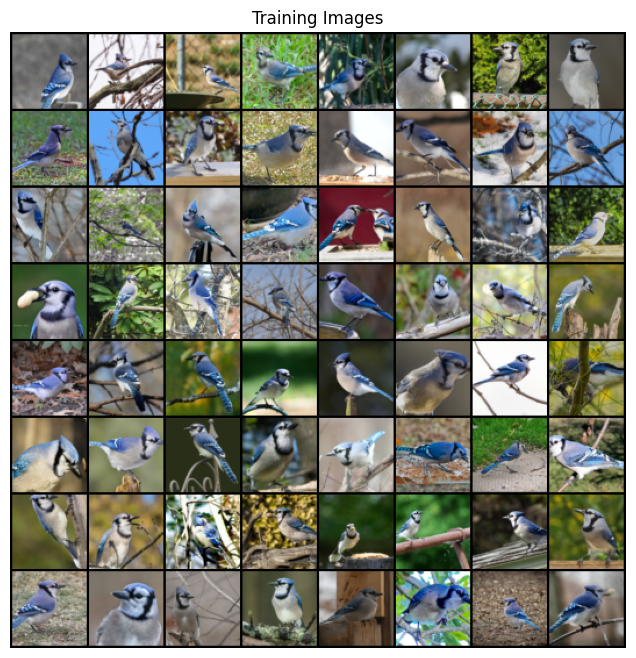

In [ ]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/50]	Loss_D: 1.5872	Loss_G: 6.6380	D(x): 0.6296	D(G(z)): 0.5840 / 0.0020
[1/5][0/50]	Loss_D: 3.2320	Loss_G: 19.7821	D(x): 0.9417	D(G(z)): 0.9456 / 0.0000
[2/5][0/50]	Loss_D: 0.4256	Loss_G: 16.1020	D(x): 0.7962	D(G(z)): 0.0000 / 0.0000
[3/5][0/50]	Loss_D: 0.9680	Loss_G: 2.1296	D(x): 0.4986	D(G(z)): 0.0304 / 0.1445
[4/5][0/50]	Loss_D: 0.9769	Loss_G: 4.1334	D(x): 0.7546	D(G(z)): 0.4230 / 0.0264


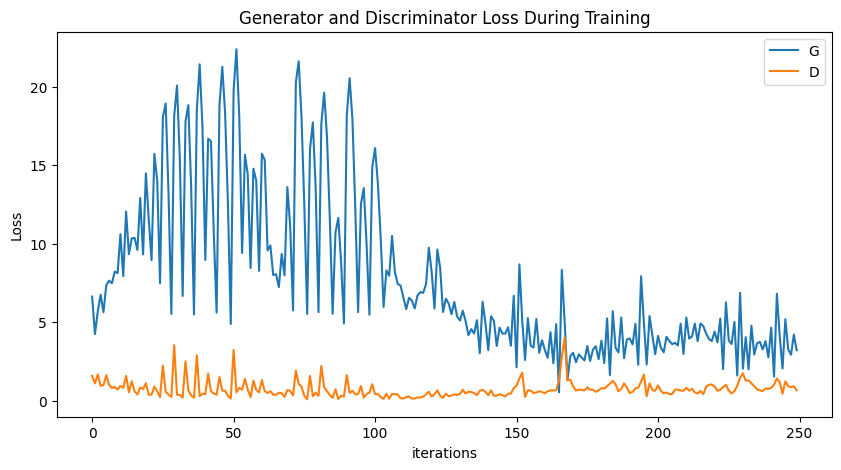

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

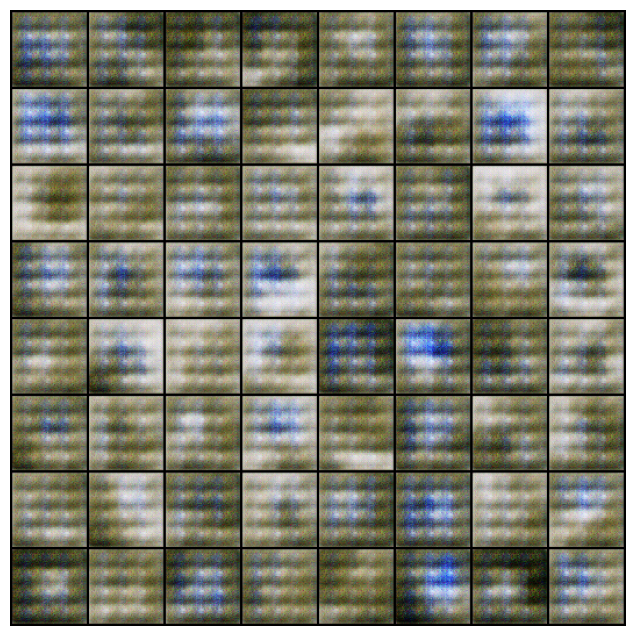

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())